### Task:
- Apply ML with a `Decision Tree (DT) Classifier` and a `Random Forest (RF) Classifier`.

---
#### A Decision Tree Classifier is a supervised machine learning algorithm used for classification tasks. It builds a model in the form of a tree structure, where each internal node represents a "test" on an attribute (feature), each branch represents the outcome of the test, and each leaf node represents a class label (the final decision).

### Quick Comparison: Decision Tree vs Linear & Logistic Regression

- <u>Type of Target:</u> Linear → continuous, Logistic → categorical (binary or multiclass), Decision Tree → categorical (classification) or continuous (regression variant).

- <u>Model Form:</u> Linear/Logistic learn coefficients (linear decision boundary), Decision Tree learns hierarchical rules (if-else splits).

- <u>Feature Scaling:</u> Linear/Logistic often benefit from scaling; Decision Trees do not need scaling.

- <u>Non-linearity & Interactions:</u> Decision Trees naturally model nonlinearity and interactions; Linear/Logistic need feature engineering for that.

- <u>Interpretability:</u> Linear models give coefficients (direction + magnitude); Decision Trees give explicit rules and feature importances (easy to visualize).

- <u>Overfitting:</u> Trees overfit easily unless pruned; linear/logistic less prone but can underfit if relationships are nonlinear.

- <u>Probabilities:</u> Logistic gives calibrated probabilities by design; Decision Trees give probability estimates from leaf proportions (may be less smooth).

In [22]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

**Note:** Decision Trees don’t require feature scaling (unlike Linear Regression where scaling often helps), so no need of importing `MinMaxScaler` here

In [ ]:
camera = pd.read_csv('x:REDACTED\06 - DT & RF Project\camera_dataset.csv')

# from google.colab import files
# uploaded = files.upload()
# camera = pd.read_csv('camera_dataset.csv')

Saving camera_dataset.csv to camera_dataset (2).csv


In [24]:
camera.head()

,Model,Release date,Max resolution,Low resolution,Effective pixels,Zoom wide (W),Zoom tele (T),Normal focus range,Macro focus range,Storage included,Weight (inc. batteries),Dimensions,Price
0,Agfa ePhoto 1280,1997,1024.0,640.0,0.0,38.0,114.0,70.0,40.0,4.0,420.0,95.0,179.0
1,Agfa ePhoto 1680,1998,1280.0,640.0,1.0,38.0,114.0,50.0,0.0,4.0,420.0,158.0,179.0
2,Agfa ePhoto CL18,2000,640.0,0.0,0.0,45.0,45.0,0.0,0.0,2.0,0.0,0.0,179.0
3,Agfa ePhoto CL30,1999,1152.0,640.0,0.0,35.0,35.0,0.0,0.0,4.0,0.0,0.0,269.0
4,Agfa ePhoto CL30 Clik!,1999,1152.0,640.0,0.0,43.0,43.0,50.0,0.0,40.0,300.0,128.0,1299.0


In [25]:
camera.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Model                    1038 non-null   object 
 1   Release date             1038 non-null   int64  
 2   Max resolution           1038 non-null   float64
 3   Low resolution           1038 non-null   float64
 4   Effective pixels         1038 non-null   float64
 5   Zoom wide (W)            1038 non-null   float64
 6   Zoom tele (T)            1038 non-null   float64
 7   Normal focus range       1038 non-null   float64
 8   Macro focus range        1037 non-null   float64
 9   Storage included         1036 non-null   float64
 10  Weight (inc. batteries)  1036 non-null   float64
 11  Dimensions               1036 non-null   float64
 12  Price                    1038 non-null   float64
dtypes: float64(11), int64(1), object(1)
memory usage: 105.6+ KB


In [26]:
camera.isnull().sum()

,0
Model,0
Release date,0
Max resolution,0
Low resolution,0
Effective pixels,0
Zoom wide (W),0
Zoom tele (T),0
Normal focus range,0
Macro focus range,1
Storage included,2


Minimal null data but we should still fill it.

A Decision Tree can handle missing values in some implementations but scikit-learn's `DecisionTreeClassifier` expects no null data/NaNs.

In [27]:
numeric_cols = camera.select_dtypes(include=[np.number]).columns
camera[numeric_cols] = camera[numeric_cols].fillna(camera[numeric_cols].median())

print(camera.isnull().sum())  # should be zeros now

Model                      0
Release date               0
Max resolution             0
Low resolution             0
Effective pixels           0
Zoom wide (W)              0
Zoom tele (T)              0
Normal focus range         0
Macro focus range          0
Storage included           0
Weight (inc. batteries)    0
Dimensions                 0
Price                      0
dtype: int64


#### Classification target of `Price` into 3 Quantile bins: `Low`, `Medium`, `High`

- Quantile binning is a data grouping technique that divides a dataset into bins, with each bin containing a roughly equal number of observations.

In [28]:
camera['Price_Bin'] = pd.qcut(camera['Price'], q=3, labels=['Low', 'Medium', 'High'])

# encode target labels to integers
le = LabelEncoder()
camera['Price_Bin_enc'] = le.fit_transform(camera['Price_Bin'])

print("Classes:", list(le.classes_))
print(camera['Price_Bin'].value_counts())

Classes: ['High', 'Low', 'Medium']
Price_Bin
Low       409
High      334
Medium    295
Name: count, dtype: int64


**Note:** Linear regression predicts a continuous Price; logistic required a label. Here we convert continuous `Price` into categorical so we can classify.

In [29]:
# Features and Labels

# Drop columns that are identifiers or the original Price columns; keep numeric features only
X = camera.drop(columns=['Model', 'Price', 'Price_Bin', 'Price_Bin_enc'])
y = camera['Price_Bin_enc']

# If any remaining non-numeric columns exist, convert with get_dummies
X = pd.get_dummies(X, drop_first=True)

print("X shape:", X.shape, "y shape:", y.shape)

X shape: (1038, 11) y shape: (1038,)


Decision Trees can handle categorical features if encoded; numeric features are primary here. We dropped `Model` because it's an *identifier string* and often *not helpful* unless we want to use brand/model as feature. We can include it later using `get_dummies`.

In [30]:
# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (830, 11) Test: (208, 11)


**Note:** `stratify=y` preserves class proportions in train/test.

In [31]:
# Training the Decision Tree classifier
clf = DecisionTreeClassifier(random_state=42, max_depth=None)  # we can set max_depth to reduce overfitting
clf.fit(X_train, y_train)
print("Training completed.")

Training completed.


### Differences vs Linear/Logistic:

- Decision Tree is **non-parametric** and learns splits (rules) with no coefficients.
    - The size and depth of the tree are not fixed beforehand; they change based on the complexity and size of the training dataset.

- It can capture **non-linear relationships** and interactions automatically.

- It’s prone to **overfitting** if unrestricted (control with `max_depth`, `min_samples_leaf`, etc.).
    - Overfitting is when a machine learning model learns its training data too well, to the point that it includes noise and irrelevant details, causing it to perform poorly on new, unseen data.

In [32]:
# Predictions and Evaluation

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: { round(acc,3)*100 }%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 61.5%

Classification Report:
              precision    recall  f1-score   support

        High       0.66      0.58      0.62        67
         Low       0.59      0.73      0.65        82
      Medium       0.62      0.49      0.55        59

    accuracy                           0.62       208
   macro avg       0.62      0.60      0.61       208
weighted avg       0.62      0.62      0.61       208



Interpretation: accuracy and class-level precision/recall/F1. Compare these numbers to logistic results to see which approach works better.

In [33]:
feature_importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top features:\n", feature_importances.head(10))

Top features:
 Weight (inc. batteries)    0.158297
Dimensions                 0.156267
Zoom tele (T)              0.105334
Storage included           0.096094
Normal focus range         0.084165
Release date               0.076226
Zoom wide (W)              0.076015
Max resolution             0.074502
Macro focus range          0.067771
Low resolution             0.059669
dtype: float64


**Note:** Instead of coefficients (as in linear models), trees give `feature_importances_`. How much each feature contributed to reducing impurity. This is more directly interpretable as importance, but not the same directional effect as regression coefficients.

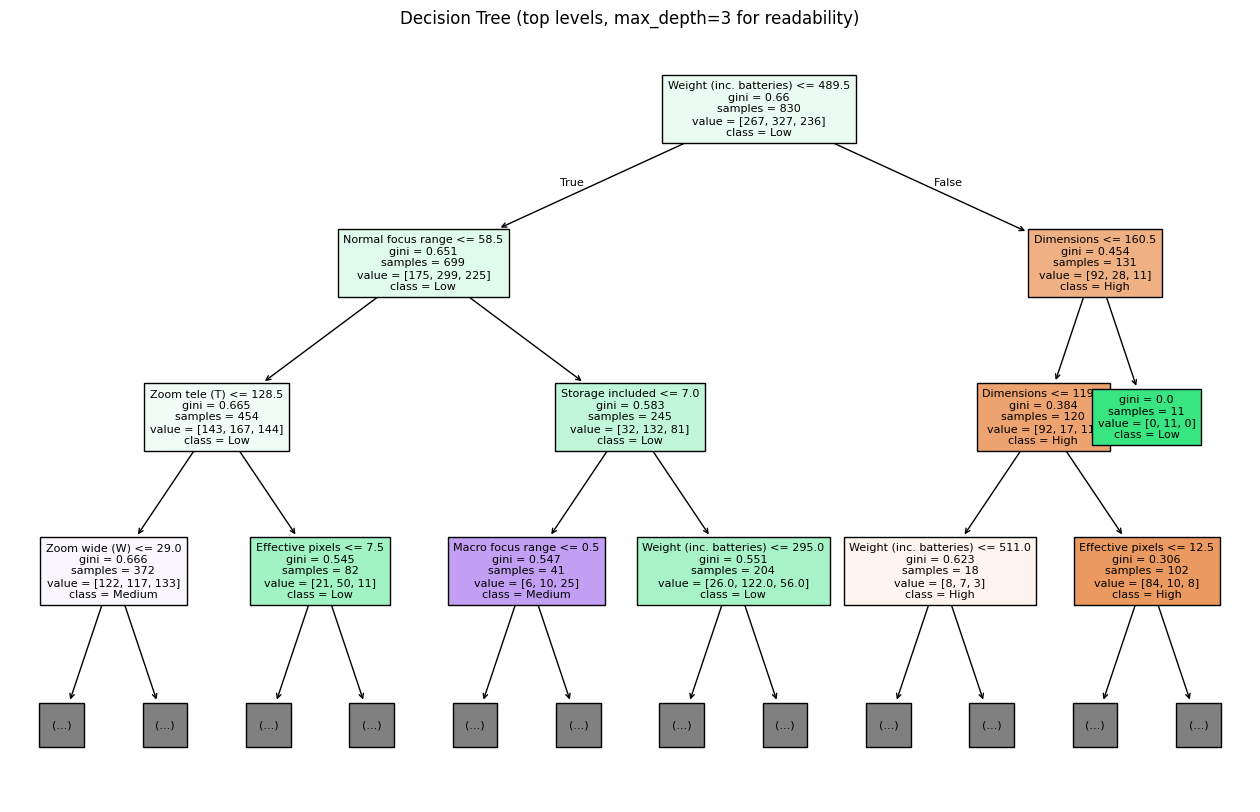

In [34]:
# Visualize the tree (Plot only limited depth for readability)
plt.figure(figsize=(16,10))
plot_tree(clf, feature_names=X.columns, class_names=le.classes_, max_depth=3, filled=True, fontsize=8)
plt.title("Decision Tree (top levels, max_depth=3 for readability)")
plt.show()

The full tree can be huge; `max_depth=3` gives a readable top portion. We can change it or export to graphviz for large trees.

In [35]:
# Retrain with limited depth
clf_pruned = DecisionTreeClassifier(random_state=42, max_depth=6, min_samples_leaf=10)
clf_pruned.fit(X_train, y_train)
print("Pruned tree accuracy:", accuracy_score(y_test, clf_pruned.predict(X_test)))

Pruned tree accuracy: 0.4855769230769231


Limiting `max_depth` and increasing `min_samples_leaf` reduces overfitting and usually improves generalization compared to an unconstrained tree.

---
#### A Random Forest (RF) Classifier is an ensemble learning method used for classification tasks. It operates by constructing a multitude of decision trees during training and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

### Quick Summary: Random Forest vs Previous Methods

- <u>Versus Linear Regression:</u> RF handles non-linear relationships and interactions automatically; doesn’t require scaling; gives feature importances instead of coefficients; better for classification when relationships are complex.

- <u>Versus Logistic Regression:</u> RF is non-linear and often more accurate on complex data, but LR is simpler and easier to interpret (LR gives direction & magnitude).

- <u>Versus Decision Tree:</u> RF is an ensemble of many tree, hence much less prone to overfitting and typically more accurate; single tree is easiest to visualize and interpret as rules.

In [36]:
# Imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

**Note:** Random Forests are an ensemble/collection of Decision Trees. They generally do not need feature scaling (like trees).

In [ ]:
# Fresh Dataset
camera = pd.read_csv('x:REDACTED\06 - DT & RF Project\camera_dataset.csv')

# from google.colab import files
# uploaded = files.upload()
# camera = pd.read_csv('camera_dataset.csv')

Saving camera_dataset.csv to camera_dataset (3).csv


In [38]:
# Fill null values
numeric_cols = camera.select_dtypes(include=[np.number]).columns
camera[numeric_cols] = camera[numeric_cols].fillna(camera[numeric_cols].median())

print(camera.isnull().sum())

Model                      0
Release date               0
Max resolution             0
Low resolution             0
Effective pixels           0
Zoom wide (W)              0
Zoom tele (T)              0
Normal focus range         0
Macro focus range          0
Storage included           0
Weight (inc. batteries)    0
Dimensions                 0
Price                      0
dtype: int64


In [39]:
# Price Bins, same as before

if 'Price_Bin' not in camera.columns:
    camera['Price_Bin'] = pd.qcut(camera['Price'], q=3, labels=['Low', 'Medium', 'High'])

# encode labels
le = LabelEncoder()
camera['Price_Bin_enc'] = le.fit_transform(camera['Price_Bin'])

print("Classes:", list(le.classes_))
print(camera['Price_Bin'].value_counts())

Classes: ['High', 'Low', 'Medium']
Price_Bin
Low       409
High      334
Medium    295
Name: count, dtype: int64


In [40]:
# 4) Features + drop identifiers
X = camera.drop(columns=['Model', 'Price', 'Price_Bin', 'Price_Bin_enc'])
y = camera['Price_Bin_enc']

# one-hot encode any non-numeric columns (if present)
X = pd.get_dummies(X, drop_first=True)

print("Feature matrix shape:", X.shape)

Feature matrix shape: (1038, 11)


In [41]:
# Split data (stratify to keep class distribution)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (830, 11) Test: (208, 11)


In [42]:
# Create + Train the Random Forest

rf = RandomForestClassifier(
    n_estimators=200,        # number of trees
    max_depth=None,          # let trees grow until pure (can adjust)
    random_state=42,
    n_jobs=-1,               # use all CPUs for speed
    oob_score=True           # out-of-bag estimate (useful)
)

rf.fit(X_train, y_train)
print("Training completed. OOB score:", rf.oob_score_)

Training completed. OOB score: 0.6855421686746987


Differences vs a single Decision Tree:

- Random Forest averages many trees to reduce overfitting and improve generalization.

- Unlike a single tree, RF is usually more accurate and robust, but less interpretable.

In [43]:
# Predictions and Evaluation

y_pred = rf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: { round(acc,3)*100 }%")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Test Accuracy: 74.0%

Classification Report:
              precision    recall  f1-score   support

        High       0.78      0.75      0.76        67
         Low       0.71      0.80      0.75        82
      Medium       0.75      0.64      0.69        59

    accuracy                           0.74       208
   macro avg       0.75      0.73      0.74       208
weighted avg       0.74      0.74      0.74       208



Top 15 features:
 Weight (inc. batteries)    0.151496
Dimensions                 0.134802
Zoom tele (T)              0.105725
Normal focus range         0.091677
Storage included           0.088048
Macro focus range          0.082980
Low resolution             0.077863
Zoom wide (W)              0.075001
Max resolution             0.072981
Release date               0.071405
Effective pixels           0.048022
dtype: float64


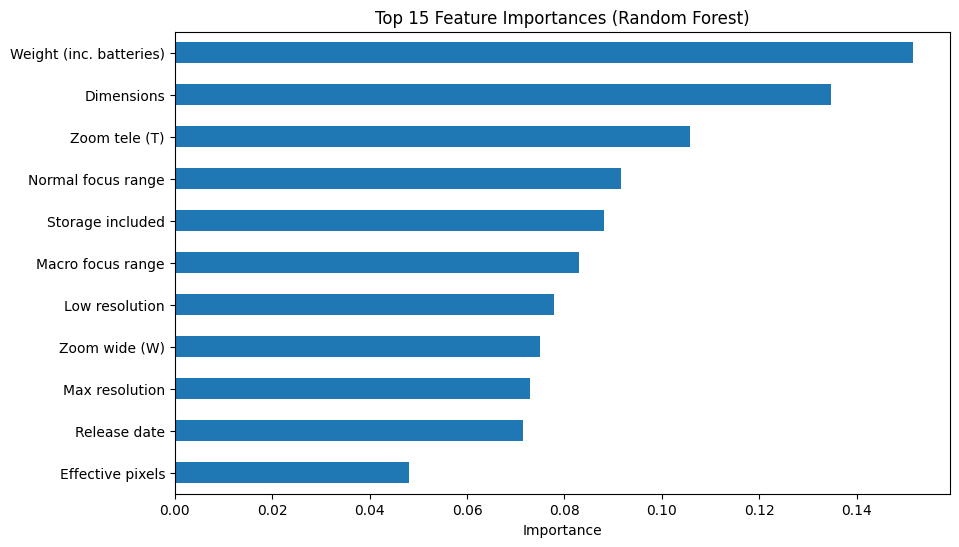

In [44]:
# Which features the forest found most useful

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("Top 15 features:\n", importances.head(15))

# simple bar plot
plt.figure(figsize=(10,6))
importances.head(15).sort_values().plot(kind='barh')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()

These importances measure how useful a feature was for splitting across all trees (no sign/direction like regression coefficients).

In [45]:
# Convert true test labels into binary form for each class
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))

# Get predicted probabilities for each class
y_score = rf.predict_proba(X_test)

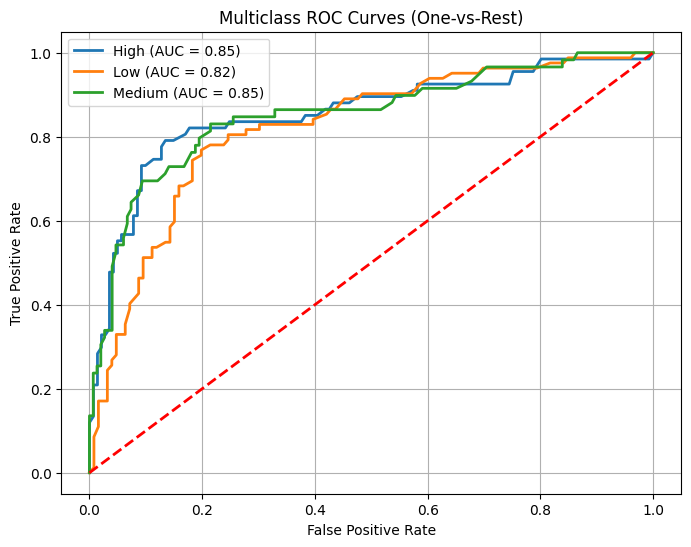

In [46]:
# Plot ROC curve for each class
plt.figure(figsize=(8,6))

for i, class_name in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_name} (AUC = {roc_auc:.2f})")

# Add reference diagonal line (random guess)
plt.plot([0, 1], [0, 1], 'r--', lw=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves (One-vs-Rest)')
plt.legend()
plt.grid(True)
plt.show()

#### How to read ROC Curve:
- Diagonal line (red dashed) → random guessing (no discrimination ability).

- Curves above the diagonal → good performance.

- Higher curve & larger AUC (closer to 1) → better at distinguishing that class from others.

- Flatter or lower curve → model struggles to separate that class.

Example interpretation for our case:

- If the curve for “`High`” price stays well above others and has `AUC = 0.92`, it means the model is very confident and accurate at identifying high-priced cameras.

- If “`Medium`” has a flatter curve and lower `AUC = 0.68`, it means the model has trouble distinguishing medium-priced ones from the other two.